<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>

Привет Максим! Меня зовут Марат, и я буду твоим ревьюером. Спешу сообщить что все ключевые этапы в работе выполнены,  с задачей тебе удалось справиться. По поводу обращения - в IT сфере принято общаться на «ты» :) Но, если привычней на «вы», дай знать. Как ревьюера моя задача помочь тебе в развитии, дав хорошие советы. Я внимательно посмотрю твой код, ознакомлюсь с твоими выводами и оставлю комментарии. Где то могу предложить небольшие исправление в коде, но ненавязчиво. Где потребуются уточнения, я оставлю много наводящих вопросов. Они помогут тебя с поиском верного решения.

Все мои комментарии размечены по цветам, для лучшего восприятия. 
    
<div class="alert alert-success">Зеленым цветом и словом «Успех» отмечены особо удачные и элегантные решения, которыми ты можешь гордиться. </div>
        
<div class="alert alert-warning">Желтым и значком словом «Совет», помечены решения у которых есть альтернативные решения, более оптимальные. Ты можешь найти их сразу и доработать проект, или отложить это на потом, для будущих проектах. Проект будет принят и без их доработки. </div>
        
<div class="alert alert-danger"> Красным цветом и значком словом «Ошибка» помечу твои решения, на которые стоит обратить внимание прежде всего. После их доработки проект будет принят. </div>
        
Залог успеха - работа сообща, взаимное уважение и работа в диалоге. Поэтому, помечай свои ответные комментарии на мои реплики заметным цветом или курсивом, так мне будет легче их отслеживать. Пожалуйста, не изменяй и не удаляй мои комментарии. Все это поможет выполнить повторную проверку быстрей.

</div>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Установка-библиотек" data-toc-modified-id="Установка-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Установка библиотек</a></span></li><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подготовка-констант" data-toc-modified-id="Подготовка-констант-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка констант</a></span></li><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Знакомство с данными</a></span></li></ul></li><li><span><a href="#BERT" data-toc-modified-id="BERT-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>BERT</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных-для-BERT" data-toc-modified-id="Подготовка-данных-для-BERT-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка данных для BERT</a></span><ul class="toc-item"><li><span><a href="#Загрузка-предобученных-модели-и-токенизатора." data-toc-modified-id="Загрузка-предобученных-модели-и-токенизатора.-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Загрузка предобученных модели и токенизатора.</a></span></li><li><span><a href="#Преобразуем-текст" data-toc-modified-id="Преобразуем-текст-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Преобразуем текст</a></span></li><li><span><a href="#Фильтруем-данные" data-toc-modified-id="Фильтруем-данные-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Фильтруем данные</a></span></li><li><span><a href="#Преобразуем-текст-предобработанных-данных" data-toc-modified-id="Преобразуем-текст-предобработанных-данных-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Преобразуем текст предобработанных данных</a></span></li><li><span><a href="#Преобразование-векторов" data-toc-modified-id="Преобразование-векторов-2.1.5"><span class="toc-item-num">2.1.5&nbsp;&nbsp;</span>Преобразование векторов</a></span></li><li><span><a href="#Преобразование-в-эмбеддинги" data-toc-modified-id="Преобразование-в-эмбеддинги-2.1.6"><span class="toc-item-num">2.1.6&nbsp;&nbsp;</span>Преобразование в эмбеддинги</a></span></li><li><span><a href="#Выгрузка-датасета" data-toc-modified-id="Выгрузка-датасета-2.1.7"><span class="toc-item-num">2.1.7&nbsp;&nbsp;</span>Выгрузка датасета</a></span></li><li><span><a href="#Загрузка-датасета" data-toc-modified-id="Загрузка-датасета-2.1.8"><span class="toc-item-num">2.1.8&nbsp;&nbsp;</span>Загрузка датасета</a></span></li></ul></li><li><span><a href="#Обучение-для-BERT" data-toc-modified-id="Обучение-для-BERT-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение для BERT</a></span><ul class="toc-item"><li><span><a href="#Ограничение-датасета" data-toc-modified-id="Ограничение-датасета-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Ограничение датасета</a></span></li><li><span><a href="#Разбиение-данных" data-toc-modified-id="Разбиение-данных-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Разбиение данных</a></span></li><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#Модель-опорных-векторов" data-toc-modified-id="Модель-опорных-векторов-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Модель опорных векторов</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-2.2.5"><span class="toc-item-num">2.2.5&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.2.6"><span class="toc-item-num">2.2.6&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Выводы-по-методу-BERT" data-toc-modified-id="Выводы-по-методу-BERT-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Выводы по методу BERT</a></span></li></ul></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>TF-IDF</a></span><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Подгрузка-необходимых-данных" data-toc-modified-id="Подгрузка-необходимых-данных-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Подгрузка необходимых данных</a></span></li><li><span><a href="#Функция-очистки-текста" data-toc-modified-id="Функция-очистки-текста-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Функция очистки текста</a></span></li><li><span><a href="#Лемматизатор" data-toc-modified-id="Лемматизатор-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Лемматизатор</a></span></li><li><span><a href="#Выгрузка-датасета" data-toc-modified-id="Выгрузка-датасета-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Выгрузка датасета</a></span></li><li><span><a href="#Загрузка-лемматизированного-датасета" data-toc-modified-id="Загрузка-лемматизированного-датасета-3.1.5"><span class="toc-item-num">3.1.5&nbsp;&nbsp;</span>Загрузка лемматизированного датасета</a></span></li><li><span><a href="#Облако-слов" data-toc-modified-id="Облако-слов-3.1.6"><span class="toc-item-num">3.1.6&nbsp;&nbsp;</span>Облако слов</a></span></li></ul></li><li><span><a href="#Обучение-для-TF-IDF" data-toc-modified-id="Обучение-для-TF-IDF-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение для TF-IDF</a></span><ul class="toc-item"><li><span><a href="#Разбиение-данных" data-toc-modified-id="Разбиение-данных-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Разбиение данных</a></span></li><li><span><a href="#Вводим-стоп-слова" data-toc-modified-id="Вводим-стоп-слова-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Вводим стоп слова</a></span></li><li><span><a href="#Мешки-слов" data-toc-modified-id="Мешки-слов-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Мешки слов</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#Модель-опорных-векторов" data-toc-modified-id="Модель-опорных-векторов-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Модель опорных векторов</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Выводы-по-методу-TF-IDF" data-toc-modified-id="Выводы-по-методу-TF-IDF-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Выводы по методу TF-IDF</a></span></li><li><span><a href="#Проверяем-лучшую-модель" data-toc-modified-id="Проверяем-лучшую-модель-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Проверяем лучшую модель</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Вступление в работу очень важно, так человек, который смотрит твой проект (и на работе в том числе) будет сразу введен в курс дела. 
     
    
 

<div class="alert alert-warning">


Совет: 
   
Вопросик, при желании можешь ответить )
    
    
- а почему по твоему была выбрана метрика f1? 
    
    
- а что если бы нам было нужно найти как можно больше токсичных комментариев, в этом случаи на какую метрику мы бы ориентировались?
    
    
- каким образом мы можем изменить функцию ошибки в модели, чтобы она максимизировала интересующую нас метрику (accuracy, f1, precision, roc-auc итп)?    



</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Марат, привет, ниже попытался ответить на вопросы, но понял, что не знаю точный ответ на второй и совсем не знаю на третий. Попрошу тебя самого ответить на них, было бы полезно понять это.</div>

1. Для оценки токсичности комментариев используется метрика `F1`, так как имеется сильный дисбаланс классов. `Accuracy` является метрикой, которая будет работать только при сбалансированнных классах.

`F1` метрика включает в себя сразу две метрики: `precision` (доля истинноположительных из набора всех положительных, в т.ч. отрицательноположительных) и `recall` (доля истинноположительных из всего набора положительного класса, т.е. включая ложноотрицательные предсказания). Таким образом, увеличение метрики `F1` влечет за собой:

- либо уменьшение доли ложноположительных предсказаний (по метрике `precision`),
- либо уменьшение доли ложноотрицательных предсказаний (по метрике `recall`),
- либо оба варианта сразу.

2. Тут имеется в виду `precision`? Не столько важно, какая будет метрика, важно, чтобы было, грубо говоря, отобрано как можно больше комментариев класса положительный, даже если это будет ложноположительный?


3. Не знаю ответ, либо не понял вопрос.

## Подготовка

### Установка библиотек

In [1]:
# pip install nltk # доустанавливаем необходимые библиотеки
# pip install pywsd
# pip install transformers

### Импорт библиотек

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers as ppb # pytorch transformers
import requests #получить финальный url я.диска
import lightgbm as lgb
import nltk
import re
import warnings

In [132]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from pandas.core.common import flatten
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer 

from tqdm import notebook
from tqdm import tqdm
from urllib.parse import urlencode # для задания адреса таблицы в я.диске
from pywsd.utils import lemmatize_sentence #лемматизатор
from nltk.corpus import wordnet
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет:

    

    
- есть рекомендации PEP-8 при написании кода, в том числе и для импортов. Если интересно можешь почитать [тут](https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html). Есть что поправить 



<div class="alert alert-info"> <b>Комментарий студента:</b> Сделано.</div>

### Подготовка констант

In [5]:
RANDOM_STATE = 100
max_len = 512

### Знакомство с данными

In [70]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv(r'C:\Users\maxpe\Downloads\Practicum\Projects\datasets\toxic_comments.csv', index_col=0)
display(df.shape);

(159292, 2)

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка:
    
Мне пришлось подправить твой код чтобы запустилось. Для некоторых особо строгих ревьюеров это основание завернуть работу без проверки, так что будь внимательней в следующий раз 
    
  
	df = pd.read_csv('/datasets/toxic_comments.csv')    

    
<div class="alert alert-warning">

Совет: 


Если не знаешь - чтобы не было столбца  `Unnamed: 0` при чтении файла можно так:


    pd.read_csv(..., index_col=0)

    
(`Unnamed: 0` появляется при не совсем корректном сохранении файла)    

<div>    

<div class="alert alert-info"> <b>Комментарий студента:</b> Прошу прощения, исправил</div>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [8]:
df.sample(7)

,text,toxic
5673,Phuu. That's warm. How do you cope?,0
26677,"When using the tag on an article, you need to...",0
51032,"""\n\n RE: I Think This Should Be Deleted \nTo ...",0
60335,"""\n\n Citation quality \n\nFirst thing, I kiss...",0
129851,"Jim1138, there was no edit warring. You kept a...",0
89330,Thank you for your response. I have since bloc...,0
9004,"You jumped the gun here, you should not really...",0


Датасет не содержит пустых строк, состоит из 2 столбцов, один из которых будет преобразован в признаки (`text`), а `toxic` - целевой признак.

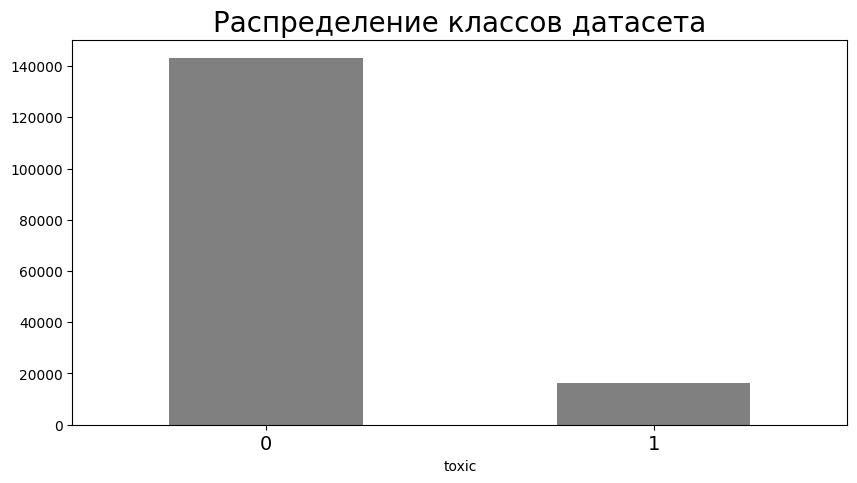

In [8]:
bar = df.groupby('toxic')['toxic'].count()
bar.plot(kind='bar', figsize=(10, 5), color='grey') #столб.диаграмма по сводной таблице с указанным размером
bw = 0.3 #толщина столбика
plt.title('Распределение классов датасета', fontsize=20) #имя графика
plt.xticks(fontsize=14, rotation=0); #показать подпись, убрать поворот

In [14]:
print(round((df['toxic'].count() - df['toxic'].sum()) / df['toxic'].count() * 100, 2), '%')

89.84 %


Наблюдаем сильный дисбаланс классов. Нетоксичных комментариев почти 90%.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

Данные изучены. Небольшой EDA не помешает, так как это аналитический проект. 


Плюс за

    

- промужуточный вывод в конце раздела


<div class="alert alert-warning">

Совет: 



- стоило еще проверить на сбалансированность классов в таргете это важная информация при моделировании и  корректной оценки модели. и к нему график можно, ведь красивый, хорошо оформленный график может быть украшением проекта. 


    

    
- .sample вместо .head, ведь если данные каким то образом упорядоченны, то шансы увидеть что то разнообразное через .sample чуть выше чем через .head (или .tail)     
   





</div>




<div class="alert alert-info"> <b>Комментарий студента:</b> Сделано</div>

## BERT

### Подготовка данных для BERT

#### Загрузка предобученных модели и токенизатора.

In [15]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights);

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:



Принято




<div class="alert alert-warning">



Совет: 

Есть модели обученных на специальных в текстах и предназначенные для специальных целей, их можно поискать на  на huggingface. Там авторы указывают,на каких данных учили и для каких целей, можно поискать. В частности для нашего датосета возможно будут интересна модель  toxic-bert. Судя по названию она самое то )

<div class="alert alert-info"> <b>Комментарий студента:</b> Честно говоря, не нашел ни примеров синтаксиса, ни ведеоматериалов, чтобы с текущими знаниями получилось реализовать BERT иначе.</div>

Проверим любой рандомный текст.

In [16]:
tokenizer.encode('You, sir, are my hero. Any chance you remember..', add_special_tokens=True)

[101,
 2017,
 1010,
 2909,
 1010,
 2024,
 2026,
 5394,
 1012,
 2151,
 3382,
 2017,
 3342,
 1012,
 1012,
 102]

Токенизатор отрабатывает корректно. Применим его предварительно к датасету.

#### Преобразуем текст

In [17]:
pre_tokenized = df['text'].apply(
  lambda x: tokenizer.encode(x, add_special_tokens=True)) 

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


In [18]:
pre_tokenized

0         [101, 7526, 2339, 1996, 10086, 2015, 2081, 210...
1         [101, 1040, 1005, 22091, 2860, 999, 2002, 3503...
2         [101, 4931, 2158, 1010, 1045, 1005, 1049, 2428...
3         [101, 1000, 2062, 1045, 2064, 1005, 1056, 2191...
4         [101, 2017, 1010, 2909, 1010, 2024, 2026, 5394...
                                ...                        
159446    [101, 1000, 1024, 1024, 1024, 1024, 1024, 1998...
159447    [101, 2017, 2323, 2022, 14984, 1997, 4426, 200...
159448    [101, 13183, 6290, 26114, 1010, 2045, 2015, 20...
159449    [101, 1998, 2009, 3504, 2066, 2009, 2001, 2941...
159450    [101, 1000, 1998, 1012, 1012, 1012, 1045, 2428...
Name: text, Length: 159292, dtype: object

Как видим из сообщения к `pre_tokenized`, имеем ограничение в 512 токенов в строке. Создадим такое ограничение.

#### Фильтруем данные

Собираем датасет из токенизированных данных - столбец `text`, целевого признака и длин списков токенов.

In [19]:
df_temp = pd.DataFrame(pre_tokenized)
df_temp['toxic'] = df['toxic']
len_list = []
for i in df_temp['text']:
    len_list.append(len(i))
df_temp['len'] = len_list
df_temp

,text,toxic,len
0,"[101, 7526, 2339, 1996, 10086, 2015, 2081, 210...",0,68
1,"[101, 1040, 1005, 22091, 2860, 999, 2002, 3503...",0,35
2,"[101, 4931, 2158, 1010, 1045, 1005, 1049, 2428...",0,54
3,"[101, 1000, 2062, 1045, 2064, 1005, 1056, 2191...",0,144
4,"[101, 2017, 1010, 2909, 1010, 2024, 2026, 5394...",0,21
...,...,...,...
159446,"[101, 1000, 1024, 1024, 1024, 1024, 1024, 1998...",0,68
159447,"[101, 2017, 2323, 2022, 14984, 1997, 4426, 200...",0,27
159448,"[101, 13183, 6290, 26114, 1010, 2045, 2015, 20...",0,19
159449,"[101, 1998, 2009, 3504, 2066, 2009, 2001, 2941...",0,28


Удаляем строки с превышающими лимит токенами. таких строк порядка 1.8%

In [20]:
df_temp = df_temp.loc[df_temp['len'] < 513].drop(['len'], axis=1)

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:


Можно было подать с такими аргументами    

    df['text'].apply(lambda x: tokenizer.encode(x, 
                                                            max_length=512,
                                                            padding='max_length',
                                                            truncation=True,
                                                            add_special_tokens=True)


<div class="alert alert-info"> <b>Комментарий студента:</b> Вот этого я как раз не хотел делать, чтобы не обрезать текст. Вдруг в обрезках были бы слова, которые дают категорию 1. Лучше полность исключить строки, их не так много. Я неправ?</div>

Собираем данные по индексу: слева - тексты из исходного датасета, справа - целевой признак из нового, отфильтрованного датасета. Так как `join` имеет значение `inner`, то остаются только те строки, в которых совпадает индекс, то есть прошедшие фильтрацию.

In [21]:
df_left = df['text']
df_right = df_temp['toxic']
result = pd.concat([df_left, df_right], axis=1, join="inner")
result

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


В случае преобразования в эмбенддинги внутри ноутбука, код ниже - указывает количество семплов для будущего датасета, где `q_sample = len(result)` - это полный датасет.

Ниже приведен пример расчета для очень маленькой выборки - взяли 256 строк, чтобы показать работоспособность кода. 

Полный преобразованный датасет будет использоваться уже на этапе разделения признаков и целевого признака.

In [22]:
q_sample = 256 # нужное число для датасета, вплоть до q_sample = len(result)
result = result.sample(q_sample).reset_index(drop=True)

#### Преобразуем текст предобработанных данных

Токенизируем отфильтрованную выборку.

In [23]:
tokenized = result['text'].apply(
  lambda x: tokenizer.encode(x, add_special_tokens=True)) 

Предупреждения больше нет. Максимальная длина токена `max_len` равна ограничению - 512. Вынесли это значения в константы.

При исполнении преобразования внутри ноутбука, `max_len` расчитывается ниже. Так как мы случайным образом отберем какое-то количество строк, может случиться, что строки будут короче константной `max_len = 512`, это нужно учитывать

In [24]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
max_len

409

#### Преобразование векторов

Паддингом добавляем к каждому вектору нули в конец, так, чтобы длина каждого вектора была равна длине `max_len`.

Маска тоже применяется к каждому вектору - значению, отличному от нуля, присваивается 1, нули остаются нулями.

In [25]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

Заранее рассчитанные данные:
- В Яндекс.Диске лежит датасет, содержащий 78% данных (ограничение по размеру файла), при батче равном 200. Он будет прочитан позже.

Преобразование эмбеддингов было произведено в Google Colab, с использованием GPU.

#### Преобразование в эмбеддинги

In [26]:
batch_size = 32 # задаем размер батча (кратен q_sample, если уменьшаем q_sample - уменьшаем и батч)
embeddings = [] # список эмбеддингов
for i in notebook.tqdm(range(padded.shape[0] // batch_size)): # цикл по батчам, отображать прогресс будет функция notebook()
        batch = torch.IntTensor(padded[batch_size*i:batch_size*(i+1)]) # преобразуем данные в формат тензоров
        attention_mask_batch = torch.IntTensor(attention_mask[batch_size*i:batch_size*(i+1)]) # преобразуем маску
        
        with torch.no_grad(): # для ускорения вычисления функцией no_grad() в библиотеке torch укажем, что градиенты не нужны
            batch_embeddings = model(batch, attention_mask=attention_mask_batch) # чтобы получить эмбеддинги для батча, передадим модели данные и маску
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy()) # преобразуем элементы методом numpy() к типу numpy.array

df_ed = pd.DataFrame(np.concatenate(embeddings)) # соберём все эмбеддинги в матрицу признаков вызовом функции concatenate()
df_ed['toxic'] = result['toxic'] # добавляем целевой признак
df_ed

  0%|          | 0/8 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,toxic
0,0.270376,-0.109006,-0.477660,0.270684,-0.240516,-0.604802,0.764190,0.883395,-0.162878,-0.440548,...,-0.223434,0.023012,-0.216745,0.247818,0.385476,-0.331367,-0.066175,0.339361,0.561782,0
1,0.215965,-0.064486,0.171992,0.213599,0.262521,-0.149945,0.224523,0.414178,-0.083124,-0.178243,...,-0.107594,0.173650,0.084636,0.374016,0.304638,-0.209161,-0.142330,0.303607,0.599943,0
2,0.256517,-0.008255,0.000268,0.333179,0.205015,-0.249076,0.230479,0.332486,-0.057936,-0.221463,...,0.087054,-0.076492,-0.126979,0.518873,0.147304,-0.481433,-0.221487,0.474675,0.298737,0
3,-0.004680,-0.192381,0.131963,-0.306438,-0.280289,-0.481397,-0.003957,0.581554,0.180571,-0.448998,...,-0.488260,-0.225800,-0.547975,-0.103998,0.183307,-0.219604,-0.288737,0.227150,0.743948,0
4,-0.178259,0.296173,0.129975,-0.400100,-0.241940,-0.205647,0.574739,0.493405,-0.041588,-0.155493,...,-0.369010,-0.104315,-0.508261,0.367626,0.142204,0.098504,-0.296253,0.420840,0.457711,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-0.251713,-0.149814,-0.435527,-0.074261,-0.562632,-0.407684,0.437929,0.345515,0.077336,-0.280696,...,-0.183804,-0.115963,-0.593659,0.618964,0.561259,-0.459574,0.147581,0.646249,0.283916,0
252,0.026077,0.181218,-0.059621,-0.283367,-0.223145,-0.195438,0.345665,0.109532,0.319496,-0.154305,...,-0.086503,-0.017991,-0.006160,0.079280,-0.164264,-0.127958,-0.419423,0.550043,0.654435,0
253,-0.892689,0.098495,0.402001,-0.179198,0.137741,-0.361135,-0.106007,0.093611,0.043195,-0.156481,...,-0.015632,0.000749,-0.558394,-0.010419,-0.050655,-0.111066,-0.523665,0.556151,0.793079,0
254,-0.077887,-0.416015,0.199894,-0.370491,-0.159890,-0.388170,0.101460,0.638184,0.218372,-0.756674,...,-0.413653,-0.117157,-0.575325,-0.077441,-0.058787,-0.572139,-0.151710,0.002426,0.684834,0



<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:




- Обычно размер бача берут 32 или 64/128 (что-то кратное 2^N), чтобы код бежал быстрее.
    
    


<div class="alert alert-info"> <b>Комментарий студента:</b> Про это не знал, в теории про это не было ни слова. Спасибо</div>

Код выше, показывает механизм преобразования эмбеддингов на маленькой выборке. То же самое было расчитано на всем датасете. Прочитаем его.

#### Выгрузка датасета

In [ ]:
# df_ed.to_csv('df_ed_20k.csv', index=False)

Выгружаем датасет после этапа преобразования в эмбеддинги, для того, чтобы не пересчитывать их в следующий сеанс или на другом устройстве. Выгрузка датасета закомментирована, она не должна больше исполняться.

#### Загрузка датасета

Рассчитанные эмбендинги в Colab я сохранил в Яндекс.Диске. Здесь сохранен неполный датасет, порядка 78% от исходного. Прочитаем `csv-файл`.

In [27]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/KLot7E--emZcKg' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url)
df_ed_78 = pd.read_csv(download_url, sep=',')
df_ed_78

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,toxic
0,-0.214180,0.147004,-0.198792,0.039257,-0.117727,-0.340003,-0.144716,0.312527,-0.208113,-0.603441,...,-0.209616,0.381346,0.129333,0.156410,-0.196734,-0.076245,-0.302536,0.222647,0.358534,0
1,0.352702,0.166299,0.279629,-0.027249,0.170146,-0.320978,0.132645,0.255978,-0.076715,-0.255779,...,-0.071787,-0.004774,-0.050075,0.283952,0.130654,-0.132127,-0.168120,0.573513,0.351487,1
2,-0.390808,0.389703,0.201352,-0.158126,-0.351628,-0.587400,0.745436,0.543038,0.301617,-0.075048,...,-0.401640,0.525003,-0.361147,0.151722,0.284467,-0.114487,-0.712322,0.500326,0.233124,1
3,-0.172516,-0.347529,0.091326,0.274101,-0.638771,-0.430128,0.085095,0.347237,-0.185096,-0.064509,...,0.003850,0.156936,-0.172188,-0.043264,0.498429,-0.266780,-0.493660,0.516713,0.692796,0
4,-0.525008,-0.264399,-0.078045,-0.365558,-0.029540,-0.140087,0.207137,0.112012,-0.148200,-0.204890,...,-0.169026,-0.345219,-0.417685,-0.296221,-0.003516,-0.313758,-0.492042,0.370257,0.604431,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121363,-0.212598,0.256898,-0.447700,0.227991,0.286868,-0.134953,0.286301,0.290358,-0.119520,-0.162863,...,0.228032,0.299517,-0.117757,0.055547,0.581419,-0.358383,-0.404726,0.595774,0.296562,0
121364,0.159202,0.578980,0.106536,-0.247540,-0.566379,-0.770876,0.918120,0.894100,0.635024,-0.554825,...,-0.121072,0.448461,-0.421211,-0.195475,0.213188,-0.265779,-0.492184,0.749388,0.467811,1
121365,-0.183408,-0.071542,-0.303102,-0.209128,-0.538787,-0.419055,0.380409,0.182944,0.382511,-0.468929,...,-0.184913,-0.053646,-0.508643,-0.307283,0.272276,-0.089274,0.003302,0.500062,0.727596,0
121366,-0.865203,-0.198704,-0.309393,-0.249649,-0.151374,0.112604,0.326239,0.257939,-0.153978,-0.107524,...,0.156371,-0.256471,-0.130817,0.261458,-0.010640,-0.337773,-0.589161,0.084944,0.195185,0


In [28]:
df_ed_78 = df_ed_78.astype('float32') #меняем тип - чтобы при работе с данными требовалось меньше памяти
df_ed_78['toxic'] = df_ed_78['toxic'].astype('int16')

### Обучение для BERT

#### Ограничение датасета

Так как датасет получается тяжелым, чтобы была возможность на его данных провести обучение, их нужно немного разделить. Сделаем это с помощью `train_test_split`, чтобы сохранить соотношение в целевом признаке.

Таблица `out` - это таблица неиспользуемых данных. Их слишком много, чтобы оборудование было способно их обработать.

Соотношение 0.1 - это 10% на второй сет в сплите, то есть порядка 12 тысяч строк будет при таком соотношении во втором датасете.

In [32]:
out, df_ed = train_test_split(df_ed_78, test_size=0.1, random_state=RANDOM_STATE, stratify= df_ed_78['toxic']) 

In [33]:
df_ed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12137 entries, 39465 to 20976
Columns: 769 entries, 0 to toxic
dtypes: float32(768), int16(1)
memory usage: 35.7 MB


#### Разбиение данных

In [34]:
features_train, features_test, target_train, target_test = train_test_split( #создаем 4 датасета, два признаков (тест+валидация) и два целевых, 
    df_ed.drop(columns='toxic'), #для датасетов признаков удаляем целевой
    df_ed['toxic'], #для целевого оставляем только целевой
    test_size=0.2, #с соотношением 
    random_state=RANDOM_STATE, #с заданной опорой для рандома 
    stratify= df_ed['toxic']) #с заданной стратификацией по целевому признаку

#### Модель логистической регрессии

In [78]:
%%time

log_reg = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight= 'balanced') #максимальное количество итераций 1000, 
parameters = {'max_iter': range (100, 1000, 100), 'C': np.arange(0.1, 1.0, 0.1)} #перебор гиперпараметров
rand_log_reg = RandomizedSearchCV(log_reg, n_iter=20, param_distributions= parameters, scoring='f1', n_jobs= -3, cv=3)
rand_log_reg.fit(features_train, target_train.values)

best_log_reg = rand_log_reg.best_score_

print("Лучшие параметры для модели логистической регрессии с "\
    "использованием кросс-валидации:", rand_log_reg.best_params_)
print("Наибольшее значение метрики F1 для модели логистической регрессии "\
    "при лучших гиперпараметрах с использованием кросс-валидации:", best_log_reg)

Лучшие параметры для модели логистической регрессии с использованием кросс-валидации: {'max_iter': 800, 'C': 0.8}
Наибольшее значение метрики F1 для модели логистической регрессии при лучших гиперпараметрах с использованием кросс-валидации: 0.6494990514316098
CPU times: total: 3.25 s
Wall time: 37.3 s


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка:


Не забываем при инициализации модели о random_state, иначе после каждого запуска кода у нас может быть разный результат. Это касается очень многих моделей


</div>


<div class="alert alert-info"> <b>Комментарий студента:</b> Справедливо, исправил</div>

#### Модель опорных векторов

In [88]:
%%time

svclassifier = SVC(kernel='linear', random_state=RANDOM_STATE, class_weight= 'balanced') #максимальное количество итераций 1000, 
parameters = {'C': np.arange(0.05, 1.0, 0.05)} #перебор гиперпараметров
rand_svclassifier = RandomizedSearchCV(svclassifier, n_iter=10, param_distributions= parameters, scoring='f1', n_jobs= -3, cv=3)
rand_svclassifier.fit(features_train, target_train.values)

best_svclassifier = rand_svclassifier.best_score_

print("Лучшие параметры для модели SVC с "\
    "использованием кросс-валидации:", rand_svclassifier.best_params_)
print("Наибольшее значение метрики F1 для модели SVC "\
    "при лучших гиперпараметрах с использованием кросс-валидации:", best_svclassifier)

Лучшие параметры для модели SVC с использованием кросс-валидации: {'C': 0.05}
Наибольшее значение метрики F1 для модели SVC при лучших гиперпараметрах с использованием кросс-валидации: 0.6227423902616643
CPU times: total: 7.28 s
Wall time: 1min 26s


#### Модель случайного леса

In [81]:
%%time

forest = RandomForestClassifier(random_state=RANDOM_STATE, class_weight= 'balanced') #модель случайного леса
parameters = {'n_estimators': range (1, 300), 'max_depth': range (1, 50)} #перебор гиперпараметров
#применение метода гридсёрч со встроенной кросс-валидацией к модели леса с перебором указанных параметров

randomized_forest = RandomizedSearchCV(forest, n_iter=20, param_distributions= parameters, scoring='f1', n_jobs= -3, cv=5)
#обучение модели
randomized_forest.fit(features_train, target_train.values)

#лучшее значение после перебора параметров 
best_forest = randomized_forest.best_score_

print("Лучшие параметры для модели случайного леса с "\
    "использованием кросс-валидации:", randomized_forest.best_params_)
print("Наибольшее значение метрики F1 для модели случайного леса "\
    "при лучших гиперпараметрах с использованием кросс-валидации:", best_forest)

Лучшие параметры для модели случайного леса с использованием кросс-валидации: {'n_estimators': 6, 'max_depth': 7}
Наибольшее значение метрики F1 для модели случайного леса при лучших гиперпараметрах с использованием кросс-валидации: 0.5553040863929963
CPU times: total: 609 ms
Wall time: 2min 18s


#### LightGBM

In [82]:
%%time

lgbm = lgb.LGBMClassifier(class_weight= 'balanced') #
parameters = {'n_estimators': range (1, 1000), 'max_depth': range (1, 100), 'learning_rate': np.arange(0.05, 0.5, 0.05)}
#применение метода гридсёрч со встроенной кросс-валидацией

rand_lgbm = RandomizedSearchCV(lgbm, n_iter=20, param_distributions= parameters, scoring='f1', n_jobs= -3, cv=5)
#обучение модели
rand_lgbm.fit(features_train, target_train.values)

#лучшее значение после перебора параметров 
best_lgbm = rand_lgbm.best_score_

print("Лучшие параметры для модели LGBMClassifier с "\
    "использованием кросс-валидации:", rand_lgbm.best_params_)
print("Наибольшее значение метрики F1 для модели LGBMClassifier "\
    "при лучших гиперпараметрах с использованием кросс-валидации:", best_lgbm)

Лучшие параметры для модели LGBMClassifier с использованием кросс-валидации: {'n_estimators': 592, 'max_depth': 69, 'learning_rate': 0.35000000000000003}
Наибольшее значение метрики F1 для модели LGBMClassifier при лучших гиперпараметрах с использованием кросс-валидации: 0.6702944547451882
CPU times: total: 1min 9s
Wall time: 9min 14s


### Выводы по методу BERT

In [90]:
models = ['Логистическая регрессия', 'Модель опорных векторов', 'Случайный лес', 'LGBMClassifier']
F1 = [best_log_reg, best_svclassifier, best_forest, best_lgbm]
total_time = ['~1 минута', '~1.5 минут', '~3 минуты', '~10 минут']

bert_result_table = pd.DataFrame({ #созаем датафрейм
    'Модель': models, #
    'Значение метрики F1': F1,
    'Время расчета (~10 000 строк)': total_time
}) #
bert_result_table

,Модель,Значение метрики F1,Время расчета (~10 000 строк)
0,Логистическая регрессия,0.649499,~1 минута
1,Модель опорных векторов,0.622742,~1.5 минут
2,Случайный лес,0.555304,~3 минуты
3,LGBMClassifier,0.670294,~10 минут


Мы получили довольно неплохие показатели метрики `F1` на модели `LGBMClassifier`, самые высокие для метода `BERT` для сильно урезанной выборки. В то же время, модель самая медленная. Модели векторов и регрессии обучаются на порядок быстрее, а значение метрики уступает совсем немного. Модель леса показывает очень плохой результат: она не быстрая и с низким зачеством метрики `F1`

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>



Успех 👍:



Здорово Что использовал коллаб и GPU.  Если хочешь всё-таки попробовать получить метрику выше то можно сделать перебор гиперпараметров модели, или/и используй toxic-bert




</div>


## TF-IDF

Оценка важности слова определяется величиной `TF-IDF`. `TF` отвечает за количество упоминаний слова в отдельном тексте, а `IDF` отражает частоту его употребления во всём корпусе.

### Подготовка

#### Подгрузка необходимых данных

In [9]:
dft = df.copy() #исходный датасет, до преобразований BERTa
df_check = df.sample(200) #таблица для проверки работоспособности лемматизатора

In [10]:
#загружаем необходимые дополнения для библиотеки
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet') 
nltk.download('punkt')
nltk.download('stopwords') 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maxpe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxpe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxpe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxpe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
pd.options.mode.chained_assignment = None #убираем предупреждения

#### Функция очистки текста

In [12]:
def clear_text(text):

    def limit(text):
        #убираем из комментариев слова длиной от 50 до 10000 символов
        #это ограничение необходимо, т.к. есть "слово", ломающее лемматизатор
        lim = re.sub(r'\b\w{50,10000}\b', ' ', text) 
        lim1 = " ".join(lim.split()) #применяем фильтр
        return lim1

    clear = re.sub(r'[^a-zA-Z ]', ' ', limit(text)) #фильтруем латиницу, символы
    clear1 = " ".join(clear.split()) #применяем фильтр
    return clear1

#### Лемматизатор

In [13]:
def lemmatize_text(text):
    #лемматизируем текст с помощью лемматизатора предложений из пакета pywsd
    lemma = lemmatize_sentence(text) 
    return " ".join(lemma)

Лемматизатор, так же как и преобразование эмбеддингов, считается довольно долго, порядка 50 минут. Ниже лемматизирован кусочек из 100 строк оригинальной таблицы, чтобы показать работу лемматизатора.

Полный датасет рассчитан заранее и загружается после проверки.

In [14]:
tqdm.pandas()
df_check['lemma'] = df_check['text'].progress_apply(clear_text) #повторяем очистку, т.к. датасет - другой
df_check['lemma'] = df_check['lemma'].progress_apply(lemmatize_text) #лемматизируем текст
df_check.head()

100%|██████████| 200/200 [00:02<00:00, 69.42it/s]


,text,toxic,lemma
115799,Placenames with numbers \n\nPerhaps include Nu...,0,placenames with number perhaps include number ...
33157,"""\n\n Gendergap v gender gap \n\nRe this edit ...",0,gendergap v gender gap re this edit i personal...
7547,Please - DON'T ERASE CONTENT WITHOUT DISCUSSION.,0,please don t erase content without discussion
44180,Illegal usernames \nPersonally I think this ap...,0,illegal usernames personally i think this appr...
143265,One should add that a user who has been given ...,0,one should add that a user who have be give a ...


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:



- Лематизация удалась. Отличная библиотека pywsd, хотя впервые  вижу ее использование



- Плюс за использование apply, неэффективные циклы нам ни к чему.


- Да, всегда лучше проверить что получилось  в итоге, так всегда будет возможность поправить ошбку



<div class="alert alert-warning">


Совет: 


- попробуй .progress_apply, делает что .apply, но еще и показывает на какой итерации находится процесс


    
- после очистки и лемитизации можно провести частотный анализ текста/[облако слов](https://habr.com/ru/post/517410/) - чтобы получить общее представление о тематике и о наиболее часто встерчаемых словах Кроме того графики, рисунки делают проект визуально интересней
    
    

#### Выгрузка датасета

Так же, как и с таблицей после преобразования эмбеддингов `df_ed`, этот датасет был выгружен один раз, после чего вывод таблицы - закомментирован. 

Лемматизировался полный датасет `df`. 

In [98]:
# dft.to_csv('df_lemma.csv', index=False)

#### Загрузка лемматизированного датасета

In [105]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/zNN-U7f8m-UaaQ' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url)
df_lem = pd.read_csv(download_url, sep=',')
df_lem

,text,toxic,lemma
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159288,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...
159290,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


In [106]:
df_lem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
 2   lemma   159281 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


Как мы видим, появились пустые значения в столбце `lemma`, это значит, что там были только такие символы, которые не пропустил фильтр. Их нужно убрать.

In [107]:
df_lem.dropna(inplace=True)
df_lem = df_lem.reset_index(drop=True)

#### Облако слов

После очистки текста, можем просмотреть наиболее часто встречающиеся слова в датасете. Для этого сначала токенизируем текст - разобьем на составные части.

Облако слов будем делать на отдельном датасете, чтобы не перегружать рабочий. Эти данные в обучении не пригодятся.

In [110]:
df_cloud = df_lem.copy()
df_cloud['tokens'] = df_cloud['lemma']
df_cloud

,text,toxic,lemma,tokens
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...,you sir be my hero any chance you remember wha...
...,...,...,...,...
159276,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...,and for the second time of ask when your view ...
159277,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...,you should be ashamed of yourself that be a ho...
159278,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...,spitzer umm theres no actual article for prost...
159279,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...,and it look like it be actually you who put on...


In [111]:
df_cloud['tokens'] = [','.join(map(str, l)) for l in df_cloud['tokens']]
df_cloud['tokens'] = df_cloud['lemma'].progress_apply(word_tokenize) #лемматизируем текст
df_cloud.sample(5)

100%|██████████| 159281/159281 [00:33<00:00, 4709.59it/s]


,text,toxic,lemma,tokens
55335,"""45, 5 June 2006 (UTC) \n\nYou need to explain...",0,june utc you need to explain why we belong tog...,"[june, utc, you, need, to, explain, why, we, b..."
3407,Water controversy \n\nThis needs to be expande...,0,water controversy this need to be expand but i...,"[water, controversy, this, need, to, be, expan..."
60264,"Yep, I was thinking of it myself, and would ha...",0,yep i be think of it myself and would have do ...,"[yep, i, be, think, of, it, myself, and, would..."
94698,"""\n\n Is Brian really an atheist? \n\nIn the r...",0,be brian really an atheist in the recently air...,"[be, brian, really, an, atheist, in, the, rece..."
149716,This is already in the article. - Ghost,0,this be already in the article ghost,"[this, be, already, in, the, article, ghost]"


In [112]:
stop_words = set(stopwords.words('english')) 

In [113]:
tokens = (df_cloud['tokens'].tolist())
tokens = list(zip(*tokens))[0]
tokens

('explanation',
 'd',
 'hey',
 'more',
 'you',
 'congratulation',
 'cocksucker',
 'your',
 'sorry',
 'alignment',
 'fair',
 'bbq',
 'hey',
 'before',
 'oh',
 'juelz',
 'bye',
 'redirect',
 'the',
 'don',
 'regard',
 'good',
 'snowflake',
 'the',
 're',
 'radial',
 'there',
 'yes',
 'ok',
 'a',
 'how',
 'not',
 'praise',
 'i',
 'well',
 'not',
 'mainland',
 'pretty',
 'hi',
 'notability',
 'sure',
 'tfd',
 'you',
 'fuck',
 'i',
 'i',
 'you',
 'in',
 'a',
 'jmabel',
 'bi',
 'get',
 'are',
 'thanks',
 'awesome',
 'stupid',
 'tony',
 'ga',
 'my',
 'why',
 'lock',
 'a',
 'redirect',
 'christian',
 'dh',
 'all',
 'neiln',
 'i',
 'there',
 'parzival',
 'oppose',
 'i',
 'they',
 'ambiguous',
 'while',
 'take',
 'that',
 'in',
 'december',
 'hi',
 'minimization',
 'be',
 'screwjob',
 'april',
 'christ',
 'can',
 'would',
 'oh',
 'website',
 'thanks',
 'personal',
 'transliteration',
 'almost',
 'how',
 'lack',
 'thanks',
 'hi',
 'collusion',
 'thanks',
 'you',
 'however',
 'check',
 'i',
 'well

In [115]:
text = nltk.Text(tokens)
text

<Text: explanation d hey more you congratulation cocksucker your...>

In [116]:
fdist = FreqDist(text)
fdist

FreqDist({'i': 15583, 'the': 4936, 'you': 4449, 'please': 3430, 'it': 2744, 'this': 2325, 'thanks': 2307, 'a': 2016, 'hi': 1765, 'no': 1709, ...})

In [117]:
filtered_words = [word for word in tokens if word not in stopwords.words('english')]

In [118]:
filtered_words = nltk.Text(filtered_words)
filtered_words

<Text: explanation hey congratulation cocksucker sorry alignment fair bbq...>

In [119]:
filtered = FreqDist(filtered_words)
filtered

FreqDist({'please': 3430, 'thanks': 2307, 'hi': 1765, 'thank': 1423, 'redirect': 1372, 'well': 1360, 'yes': 1130, 'hello': 1121, 'hey': 1086, 'ok': 947, ...})

In [123]:
%matplotlib inline

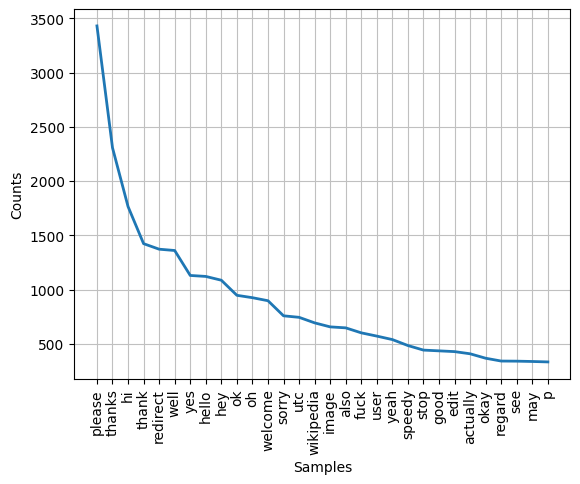

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [134]:
filtered.plot(30,cumulative=False)

### Обучение для TF-IDF

#### Разбиение данных

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет: 



Чтобы получить хорошую метрику в данном проекте важно использовать весь датсет (логистичечкая регрессия, SVM + полный датасет, даст лучше и быстрее результат, чем медленные "деревянные" модели с усеченным датасетом). Если не хватает мощности ядро обрушивается,  то тут часто проблема в использовании unicode, убираем и все бежит веселей, если и это не помогает ничего не поделать, тут студент сам смотрит что у него и как ) 



</div>


<div class="alert alert-info"> <b>Комментарий студента:</b> Я ограничил, чтобы на ревью долго не считало. Так как вектора на полном считаются 30 минут, лес 25 и т.д. Т.к. я в целом показал работоспособность кода, я убираю ограничение датасета для TF-IDF (кроме BERTa, потому что BERT и по 8 часов считал, и не выдавал ответ. Но ядро не рушил).

In [40]:
features_train_lem, features_test_lem, target_train_lem, target_test_lem = train_test_split( #создаем 4 датасета, два признаков (тест+валидация) и два целевых, 
    df_lem.drop(columns='toxic'), #для датасетов признаков удаляем целевой
    df_lem['toxic'], #для целевого оставляем только целевой
    test_size=0.2, #с соотношением 
    random_state=RANDOM_STATE, #с заданной опорой для рандома 
    stratify= df_lem['toxic']) #с заданной стратификацией по целевому признаку

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


- random_state на месте


- правильно разбил на 2 выборки (иногда студенты использующие GS разбивают на 3 датасета)

    
- здорово что используешь stratify    





#### Вводим стоп слова

Стоп-слова были введены ранее, в пункте "Облако слов".

In [41]:
# stop_words = set(stopwords.words('english')) 

Стоп слова - слова, не несущие смысловой нагрузки. Они не должны влиять на обучение.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Не забыли о стопсловах, они ни к чему и код побежит быстрей

    
<div class="alert alert-warning">


Совет:     

Вопросик:

А стопслова важней убирать  когда мы используем TF-IDF, или когда используе обычный CountVectorizer? 



<div class="alert alert-info"> <b>Комментарий студента:</b> Могу ошибаться, но, наверное при обычном CountVectorizer важнее. Т.к. метод TF-IDF использует частоту упоминаний в каждой строке и упоминания во всем корпусе, тогда слова I, a, различные предлоги и др. будут иметь меньший вес, и будут меньше влиять, чем уникальные слова. При CountVectorizer такой градации нет, поэтому оставленные в тексте стоп-слова будут влиять на обучение так же, как уникальные и редкие слова.</div>

#### Мешки слов

Создадим счётчик, далее передаём счётчику корпус текстов. Для этого вызовем `fit_transform()`. 

Счётчик выделит из корпуса уникальные слова и посчитает количество их вхождений в каждом тексте корпуса. Отдельные буквы счётчик как слова не учитывает.

In [70]:
corpus_train = features_train_lem['lemma'].values #создаем корпус текстов
count_tf_idf_train = TfidfVectorizer(stop_words=stop_words) #создаем счетчик величин TF-IDF, с учетом стоп слов
tf_idf_train = count_tf_idf_train.fit_transform(corpus_train) #передаем счётчику корпус текстов (fit запускается только на обучающей выборке)
tf_idf_train.shape

(1600, 9522)

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка:



Да, в тренажере был текст на кирилице, там перевод в unicode оправдан. В нашем случае (латиница) это лишь  увеличит количество потребляемой памяти и это в лучшем случаи, в худшем он обрушает ядро.





</div>

In [65]:
# count_tf_idf_train.get_feature_names() #посмотреть словарь уникальных слов

Аналогичным образом работаем и с тестовой выборкой. Единственное отличие - `transform` для теста не обучается.

In [71]:
corpus_test = features_test_lem['lemma'].values
tf_idf_test = count_tf_idf_train.transform(corpus_test)
tf_idf_test.shape

(400, 9522)

Данные предобработаны, можно переходить к обучению.

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Совет:


- .fit_transform на train датасете, .transform на test/valid. Вроде все верно, но после ты подаешь tf_idf_train в GridSearchCV или cross_val_score и он внутри себя разбивая его на тренировочный и валидационный датасет, получается подглядывание в будущее (утечка данных). Решение в использовании pipeline, ниже распишу







### Обучение

#### Модель логистической регрессии

In [72]:
%%time

log_reg_lem = LogisticRegression(solver='lbfgs', random_state=RANDOM_STATE, max_iter=1000, class_weight= 'balanced') #максимальное количество итераций 1000, 
log_reg_scores_lem = cross_val_score(log_reg_lem, tf_idf_train, target_train_lem.values, scoring='f1', cv=10)
log_reg_f1_lem = log_reg_scores_lem.mean()

print("Среднее значение метрики F1 для модели логистической регрессии "\
    "с использованием кросс-валидации:", log_reg_f1_lem)

Среднее значение метрики F1 для модели логистической регрессии с использованием кросс-валидации: 0.5550298252472166
CPU times: user 522 ms, sys: 4.05 ms, total: 526 ms
Wall time: 534 ms


<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>



Совет 🤔:


Логистическая регрессия показывает одни из самых высоких результатов на этом датасете (а Деревянные модели медленные, и результаты плохие), поэтому стоит поперебирать по C



#### Модель опорных векторов

In [73]:
%%time

svclassifier_lem = SVC(kernel='linear', class_weight= 'balanced') 
svclassifier_scores_lem = cross_val_score(svclassifier_lem, tf_idf_train, target_train_lem.values, scoring='f1', cv=2)
svclassifier_f1_lem = svclassifier_scores_lem.mean()

print("Среднее значение метрики F1 для модели SVC "\
    "с использованием кросс-валидации:", svclassifier_f1_lem)

Среднее значение метрики F1 для модели SVC с использованием кросс-валидации: 0.42659123055162657
CPU times: user 446 ms, sys: 153 µs, total: 446 ms
Wall time: 446 ms


#### Модель случайного леса

In [74]:
%%time

forest_lem = RandomForestClassifier(random_state=RANDOM_STATE, class_weight= 'balanced') #модель случайного леса
parameters = {'n_estimators': range (1, 500, 50), 'max_depth': range (1, 100, 10)} #перебор гиперпараметров
#применение метода гридсёрч со встроенной кросс-валидацией к модели леса с перебором указанных параметров

randomized_forest_lem = RandomizedSearchCV(forest_lem, n_iter=15, param_distributions= parameters, scoring='f1', n_jobs= -2, cv=2)
#обучение модели
randomized_forest_lem.fit(tf_idf_train, target_train_lem.values)

#лучшее значение после перебора параметров 
best_forest_lem = randomized_forest_lem.best_score_

print("Лучшие параметры для модели случайного леса с "\
    "использованием кросс-валидации:", randomized_forest_lem.best_params_)
print("Наибольшее значение метрики F1 для модели случайного леса "\
    "при лучших гиперпараметрах с использованием кросс-валидации:", best_forest_lem)

Лучшие параметры для модели случайного леса с использованием кросс-валидации: {'n_estimators': 351, 'max_depth': 1}
Наибольшее значение метрики F1 для модели случайного леса при лучших гиперпараметрах с использованием кросс-валидации: 0.3963191467112831
CPU times: user 31.4 s, sys: 237 ms, total: 31.7 s
Wall time: 31.7 s


#### LightGBM

In [55]:
%%time

lgbm_lem = lgb.LGBMClassifier(class_weight= 'balanced') #
parameters = {'n_estimators': range (1, 500, 10), 'max_depth': range (1, 100, 5), 'learning_rate': np.arange(0.1, 0.8, 0.1)}
#применение метода гридсёрч со встроенной кросс-валидацией

rand_lgbm_lem = RandomizedSearchCV(lgbm_lem, n_iter=20, param_distributions= parameters, scoring='f1', n_jobs= -2, cv=3)
#обучение модели
rand_lgbm_lem.fit(tf_idf_train, target_train_lem.values)

#лучшее значение после перебора параметров 
best_lgbm_lem = rand_lgbm_lem.best_score_

print("Лучшие параметры для модели LGBMClassifier с "\
    "использованием кросс-валидации:", rand_lgbm_lem.best_params_)
print("Наибольшее значение метрики F1 для модели LGBMClassifier "\
    "при лучших гиперпараметрах с использованием кросс-валидации:", best_lgbm_lem)

Лучшие параметры для модели LGBMClassifier с использованием кросс-валидации: {'n_estimators': 191, 'max_depth': 61, 'learning_rate': 0.30000000000000004}
Наибольшее значение метрики F1 для модели LGBMClassifier при лучших гиперпараметрах с использованием кросс-валидации: 0.30671891391315853
CPU times: user 1min, sys: 963 ms, total: 1min 1s
Wall time: 1min 1s




    

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>
    
    
    
Совет: 




Молодец что используешь GrisSearch, но в случаи TFIDF еще лучше использовать связку GridSearchCV + pipeline. 


О pipeline:

[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), это тема которая сразу затрагивает кроссвалидацию, тюнинг "векторайз", подбор гиперпараметров модели и о том что код стоит делать компактным.
    
    
- в TfidfVectorizer(stop_words=stopwords) у тебя по умолчанию ngram_range=(1, 1), тут можно подбирать разное число n- грамм (и другие параметры), максимизируя метрику, но как объединить перебор по ngram_range с обучением моделей, чтобы не делать это по отдельности или с использованием цикла?! pipeline! Готовый [пример для работы с текстами](https://medium.com/@yoni.levine/how-to-grid-search-with-a-pipeline-93147835d916). Всё что нужно там есть, хотя очень лаконично. Можешь погуглить по:


    
    pipeline nlp gridsearchcv



- как избежать ошибки подглядывания в будущее, когда мы предварительно работаем с данными (шкалирование, нормализация, TfidfVectorizer итп итд)? pipeline! особенно это важно, когда мы используем кроссвалидацию. Для TfidfVectorizer делаем .fit (обучаемся) на train, а transform на test, но точно также нужно сделать для валидационной выборки. Но GS делает валидационные внутри себя, спрашивается как добраться до нее и избежать подглядывания в будущее? Казалось бы никак, но нет! Pipeline! ) 
    
    
- pipeline позволяет делать наш код компактней и читабельней, это большой плюс, когда код будет раздуваться     
    
    

         
Если раньше не использовал pipeline то могу посоветовать видео в котором [индус](https://www.youtube.com/watch?v=mOYJCR0IDk8&ab_channel=HimanshuChandra) на английском с сильным акцентом, но на пальцах обьясняет  самое непонятное (по моему опыту): сопряженность методов fit и transform. Там же есть и код и ссылка на текст. Мне помогло )



В общем если сделать GS+pipeline будет вообще хорошо )  
    
<div>   

### Выводы по методу TF-IDF

In [58]:
models = ['Логистическая регрессия', 'Модель опорных векторов', 'Случайный лес', 'LGBMClassifier']
F1 = [log_reg_f1_lem, svclassifier_f1_lem, best_forest_lem, best_lgbm_lem]
total_time = ['~15 секунд', '~8 минут', '~6 минут', '~6 минут']

tf_result_table = pd.DataFrame({ #созаем датафрейм
    'Модель': models, #
    'Значение метрики F1': F1,
    'Время расчета (весь датасет)': total_time
}) #
tf_result_table

,Модель,Значение метрики F1,Время расчета (весь датасет)
0,Логистическая регрессия,0.555030,~15 секунд
1,Модель опорных векторов,0.426591,~8 минут
2,Случайный лес,0.396319,~6 минут
3,LGBMClassifier,0.306719,~6 минут


Мы получили два близких значения метрики F1 к требуемому: на логистической регрессии и на модели опорных векторов. Несмотря на то, что значение метрики для регрессии ниже требуемого, она все же может пригодиться, если нужно сделать довольно точные предсказания на скорость. Модель векторов, напротив, самая медленная из всех. Модель леса оказалась самой неточной. 

Единственная модель, удовлетворяющая условию - `LGBMClassifier`, дает необходимое значение метрики, к тому же предсказывает результат не дольше других моделей (а на полном наборе - быстрее других).

### Проверяем лучшую модель

Тестируем модель `LGBMClassifier`, которая при предобработке методом `TF-IDF`, показала себя как точную и достаточно быструю (даже с учетом перебора гиперпараметров) модель.

In [57]:
%%time

lgbm_lem_1 = rand_lgbm_lem.best_estimator_
lgbm_lem_1.fit(tf_idf_train, target_train_lem.values)

predictions_lgbm_lem_1 = lgbm_lem_1.predict(tf_idf_test)

lgbm_lem_f1 = f1_score(target_test_lem, predictions_lgbm_lem_1)
print("Наименьшее значение метрики F1 на тестовых данных", lgbm_lem_f1)

Наименьшее значение метрики F1 на тестовых данных 0.4473684210526316
CPU times: user 1.26 s, sys: 16 ms, total: 1.28 s
Wall time: 1.27 s



<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV</b></font>
    
    
Совет:




- Не надо воспринимать  GS как способ получить .best_params_, чтобы подставить их в модель и обучить на них. GS это сделал уже и модельку положил тут: .best_estimator_
    
    

<div class="alert alert-info"> <b>Комментарий студента:</b> Я в восторге от этого, спасибо!</div>

Получили значение метрики F1 в пределах 0,77.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех: 

- Все верно, логика моделирования не нарушена, тут тестируем только лучшую модель отобранную на валидации, или парочку лучших, если на валидации результаты близки




- Если студент получил на тесте f1 выше 0,75, это считается приемлемым результатом.


<div class="alert alert-warning">



Совет: 


Что может помочь добиться лучшего результата для (от простого)? 


- Использовать вес датасет (для TFIDF это точно возможно) 
    
    
- использовать stratify Done!
    


- можно поиграться порогом
   

- учесть дисбаланс класов в таргете. (но не oversampling, это скользкая дорожка, через class_weight) Done!


    


    
- подобрать лучшие гиперпараметры с использованием кроссвалидации (тут пригодится GridSearchCV) Done!
    


    
 - полезно настраивать векторайзеры и избегать утечки данных при использовании GS и предобработки данных  (тут пригодится pipeline)


     

- сгенерировать новые фичи, например  например посчитать число слов в тексте, длину слов итп итд. Или с помощью [тематического моделирования](https://pythobyte.com/python-for-nlp-topic-modeling-8fb3d689/) 
    
    
    



- использование предбученной модели Берта, выбрав соответствующую модель и используя полученные эмбединги, даже на небольшом тренировочном датасете можно обучить модель, которая на test покажет хорошую метрику Done!

</div>


## Выводы

В проекте было рассмотрено два метода обработки натурального языка, а именно:

- `BERT`,
- `TF-IDF`.

Преобразовав текст для `BERT`, мы получили значение метрики, не удовлетворяющее условию, а именно, метрику F1 < 0.75. Это связано с тем, что модели обучались не на всем наборе данных, а лишь на 10%. Здесь упираемся в аппаратные ограничения и скорость обучения и перебора параметров. 

В методе `TF-IDF` мы добились необходимого значения метрики `F1`, для модели `LGBMClassifier`. Она же показала результат на тестовых данных равный 0.78. Здесь омодели обучались уже на всем наборе данных, что значительно увеличило значение метрики `F1`. То есть, даже если этот метод менее точен, чем `BERT` (при условии использования 100% данных), он намного менее требователен к аппаратным ресурсам и намного быстрее.


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>



Максим, у тебя старательно выполненная работа, все четко, осмысленно. Некоторые пункты выполнены в большем чем требуется обьеме. Логика моделирования не нарушена, GS использован корректно. Если хочешь прокачать свой скилл попробуй использовать pipeline.
Я оставил небольшие советы и вопросики (если есть время и желание можешь воспользоваться/ответить).
    



Обязательное к исправлению:




- .astype('U') лишнее, стоит экономить ресурсы, иначе может даже ядро обрушиться



- не забываем о random_state
   

    
    
    
Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 


</div>


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны